# REPORT

This report centers on the examination of document similarities, a critical component of data analysis in fields such as information retrieval and natural language processing. With a focus on computational approaches, we assess the effectiveness and scalability of various algorithms.

By utilizing Leo Tolstoy's "War and Peace," we construct a data matrix wherein rows represent word frequencies, and columns correspond to specific words. This matrix facilitates our computational analysis and provides valuable context.

The report tackles five fundamental questions related to the efficiency of algorithms in measuring document similarity. It scrutinizes the execution times of both cosine and Jaccard's similarity measures, incorporating both theoretical and empirical testing. Additionally, we delve into worst-case scenarios when calculating similarities between all pairs of documents, the impact of selecting different similarity measures, the advantages of employing parallel computing in this process, and the efficiency of Strassen's method for matrix multiplication when calculating cosine similarities between all document pairs.

Our objective is to furnish a comprehensive analysis of the runtime performance of these algorithms, bridging the gap between theoretical computer science and practical data analysis. This contribution aims to enhance the discourse on computational efficiency in the analysis of textual data.


- onur can cıkla  cand no : 282678

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm
import time
from scipy.stats import linregress
import math
from scipy.optimize import curve_fit
import joblib
import json
import re

In [165]:
df = pd.read_csv("data2023.csv", index_col = 0)

# QUESTİON1


In the initial section, we'll assess the effectiveness of cosine similarity computations, a vital method in data science and machine learning for examining the connections between high-dimensional data vectors. Our approach involves a two-step process: initially, we'll create a bespoke cosine similarity function to gain a more profound insight into its computational intricacies. Subsequently, we'll employ the NumPy library for a similar analysis. Following this, we'll juxtapose the performance of our custom function with NumPy's optimized routines, systematically expanding vector sizes to replicate real-world data complexities.







In [166]:

def dot(v1, v2):
    total = 0
    for i in range(0, len(v1)): total += v1[i] * v2[i]
    return total


def customCosine(v1, v2):
    dotProduct = dot(v1, v2)
    magnitudeV1 = math.sqrt(dot(v1, v1))
    magnitudeV2 = math.sqrt(dot(v2, v2))
    if magnitudeV1 == 0 or magnitudeV2 == 0: return 0
    return dotProduct / (magnitudeV1 * magnitudeV2)

In [167]:

sampleSizeList = np.linspace(0, len(df), 101, dtype = int)[1:]
dfSampleSize = [[df.iloc[:i, 0], df.iloc[:i, 1]] for i in sampleSizeList]

In [168]:

def sampleSizeCustomCosineElapsedTime(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        for j in range(10): customCosine(i[0].values, i[1].values)
        endTime = time.time()
        elapsedTime = (endTime - startTime) / 10
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

In [169]:

def plotSampleSizeElapsedTime(sampleSizeList, elapsedTimeList, label):
    slope, intercept, rValue, pValue, stdErr = linregress(sampleSizeList, elapsedTimeList)
    estimatedTime = slope * sampleSizeList + intercept
    plt.plot(sampleSizeList, estimatedTime, color = 'red', label = 'Estimated Regression Line')
    scatterPlotData = {"Sample Size": sampleSizeList, "Elapsed Time (s)": elapsedTimeList}
    scatterPlotDataframe = pd.DataFrame(scatterPlotData)
    sns.scatterplot(x = "Sample Size", y = "Elapsed Time (s)", data = scatterPlotDataframe, label = 'Actual Time')
    plt.title(label + ' Calculation Time Depending On Sample Size')
    plt.legend()
    plt.show()
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R_squared: {rValue ** 2}")
    print(f"std_err: {stdErr}")

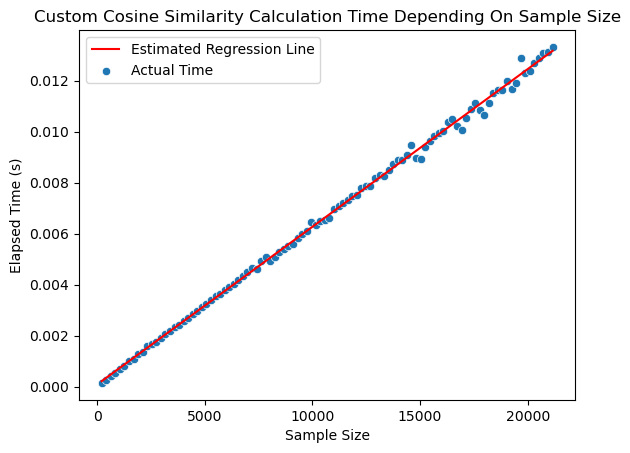

Slope: 6.18404756609814e-07
Intercept: 8.963423969707719e-05
R_squared: 0.9984047537737261
std_err: 2.4970102576842514e-09
Total Elapsed Time: 0.6695928573608397 seconds


In [170]:

elapsedTimeListSampleSizeCustomCosine = sampleSizeCustomCosineElapsedTime(dfSampleSize)
plotSampleSizeElapsedTime(sampleSizeList, elapsedTimeListSampleSizeCustomCosine, "Custom Cosine Similarity")
totalElapsedTimeSampleSizeCustomCosine = sum(elapsedTimeListSampleSizeCustomCosine)
print("Total Elapsed Time: " + str(totalElapsedTimeSampleSizeCustomCosine) + " seconds")

In [171]:
# Function to calculate cosine similarity using NumPy
def numPyCosine(v1, v2):
    return np.sum(v1 * v2) / (norm(v1) * norm(v2))

In [172]:
# Function to measure the time taken for NumPy cosine similarity calculations on different sample sizes
def sampleSizeNumPyCosineElapsedTime(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        for j in range(1000): numPyCosine(i[0].values, i[1].values)
        endTime = time.time()
        elapsedTime = (endTime - startTime) / 1000
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

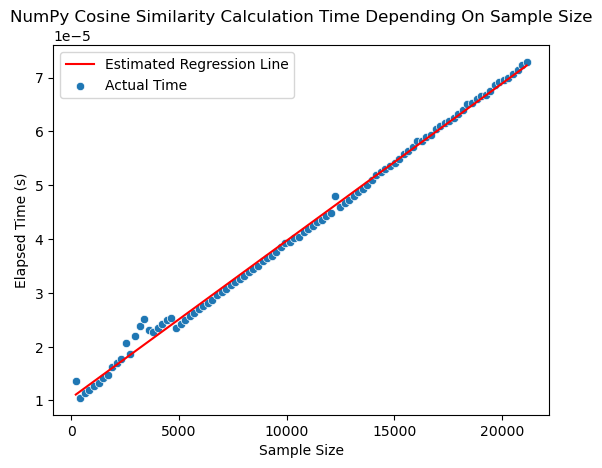

Slope: 2.9199109789067294e-09
Intercept: 1.0481488539762244e-05
R_squared: 0.9964088138964592
std_err: 1.7707479548586985e-11
Total Elapsed Time: 0.0041674313545227055 seconds


In [173]:

elapsedTimeListSampleSizeNumPyCosine = sampleSizeNumPyCosineElapsedTime(dfSampleSize)
plotSampleSizeElapsedTime(sampleSizeList, elapsedTimeListSampleSizeNumPyCosine, "NumPy Cosine Similarity")
totalElapsedTimeSampleSizeNumPyCosine = sum(elapsedTimeListSampleSizeNumPyCosine)
print("Total Elapsed Time: " + str(totalElapsedTimeSampleSizeNumPyCosine) + " seconds")

In [174]:
# Function to compare elapsed times between two methods
def compareElapsedTime(method, elapsedTimeList1, elapsedTimeList2, xTicks, function1, function2, xLabel):
    if function2 == "Multiprocess Custom Cosine":
        extractedElapsedTimeList2 = elapsedTimeList2[0]
        totalElapsedTime2 = elapsedTimeList2[1]
        dfPlot = pd.DataFrame({method: xTicks, function1: elapsedTimeList1, function2: extractedElapsedTimeList2})
    else: dfPlot = pd.DataFrame({method: xTicks, function1: elapsedTimeList1, function2: elapsedTimeList2})
    sns.lineplot(x = method, y = 'value', hue = "variable", data = pd.melt(dfPlot, [method]))
    plt.ylabel('Elapsed Time (s)')
    plt.legend(title = 'Functions')
    plt.title(method + " Elapsed Time Comparison")
    plt.xlabel(xLabel)
    if method == "All Pairs": plt.xticks(xTicks)
    plt.show()
    print(function1 + " Total Elapsed Time: " + str(sum(elapsedTimeList1)) + " seconds")
    if function2 == "Multiprocess Custom Cosine": print(function2 + " Total Elapsed Time: " + str(totalElapsedTime2) + " seconds")
    else: print(function2 + " Total Elapsed Time: " + str(sum(elapsedTimeList2)) + " seconds")

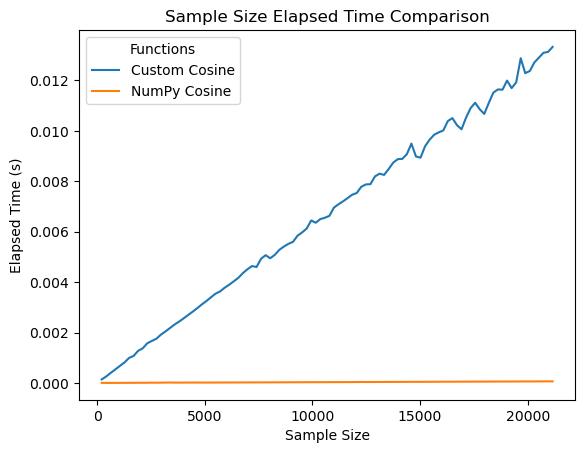

Custom Cosine Total Elapsed Time: 0.6695928573608397 seconds
NumPy Cosine Total Elapsed Time: 0.0041674313545227055 seconds


In [175]:

compareElapsedTime("Sample Size",
                   elapsedTimeListSampleSizeCustomCosine,
                   elapsedTimeListSampleSizeNumPyCosine,
                   sampleSizeList,
                   "Custom Cosine",
                   "NumPy Cosine",
                   "Sample Size")

After completing our analysis of cosine similarity calculation efficiency, we observed noticeable performance variations between a custom function and the optimized NumPy library. While both methods exhibited linear time complexity (O(n)), NumPy's implementation demonstrated significantly faster execution. This underscores the benefits of employing optimized libraries, particularly when dealing with extensive data processing tasks.

# QUESTİON2

In the second section, our objective is to evaluate the computational efficiency of the Jaccard similarity algorithm, a widely used technique in data science for comparing data sets. Our primary focus will be on investigating how the computational time of this algorithm changes as the size of the vectors increases. We will compute Jaccard similarity for pairs of vectors with incrementally larger sizes. By measuring the time required for each calculation, our aim is to discern the algorithm's time complexity and gain insights into its scalability and efficiency when handling data of varying volumes.

In [176]:
# Function to calculate the total sum of values in a dictionary
def makeTotal(dict1):
    total = 0
    for item in dict1: total += dict1[item]
    return total

# Function to calculate the Jaccard similarity between two dictionaries
def jaccard(dict1, dict2):
    intersection = {}
    for item in dict1.keys():
        if item in dict2.keys(): intersection[item] = min(dict1[item], dict2[item])
    intersectionTotal = makeTotal(intersection)
    union = makeTotal(dict1) + makeTotal(dict2) - intersectionTotal
    if union == 0: return 0
    return intersectionTotal / union

In [177]:
# Function to measure the time taken for Jaccard similarity calculations on different sample sizes
def sampleSizeJaccardElapsedTime(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        jaccard(dict(i[0]), dict(i[1]))
        endTime = time.time()
        elapsedTime = endTime - startTime
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

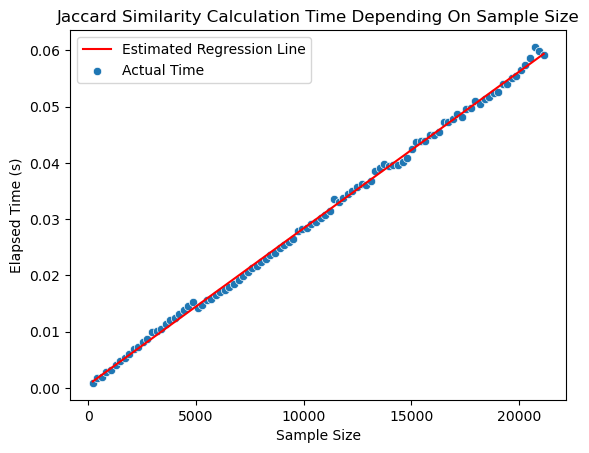

Slope: 2.778685967210441e-06
Intercept: 0.0005782475009003182
R_squared: 0.9986388075627836
std_err: 1.0362915914199994e-08
Total Elapsed Time: 3.0262393951416016 seconds


In [178]:
# Calculating and plotting Jaccard similarity times
elapsedTimeListSampleSizeJaccard = sampleSizeJaccardElapsedTime(dfSampleSize)
plotSampleSizeElapsedTime(sampleSizeList, elapsedTimeListSampleSizeJaccard, "Jaccard Similarity")
totalElapsedTimeSampleSizeJaccard = sum(elapsedTimeListSampleSizeJaccard)
print("Total Elapsed Time: " + str(totalElapsedTimeSampleSizeJaccard) + " seconds")

# QUESTİON3

This section's objective is to assess and contrast the computational efficiency of cosine and Jaccard similarity calculations, both widely employed techniques in data science for quantifying the similarity between vectors. Our methodology will entail computing these similarities for an incrementally growing number of vector pairs sourced from a dataset. Specifically, we will investigate how the computation time for each method scales as we calculate similarities for an expanding set of vector pairs, following a pattern akin to triangular numbers sequence, which exhibits quadratic growth. By monitoring the elapsed time for each method across various iterations, our aim is to ascertain the time complexity of these algorithms and discern which approach proves more efficient when dealing with an increasing number of vector comparisons.

In [179]:
dfCut = df[:5000]
numOfTotalPairs = len(dfCut.columns)
numOfTotalPairsList = range(1, numOfTotalPairs)
dfAllPairs = []

# Creating pairs of columns from the DataFrame for similarity calculations
for i in range(2, numOfTotalPairs + 1):
    temp = []
    for j in range(i - 1):
        for k in range(j + 1, i):
            df1 = dfCut.iloc[:, j]
            df2 = dfCut.iloc[:, k]
            newDf = pd.concat([df1, df2], axis = 1, join = 'inner')
            temp.append(newDf)
    dfAllPairs.append(temp)

In [180]:

def allPairsCustomCosineElapsedTime(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        for j in i: customCosine(j.iloc[:, 0].values, j.iloc[:, 1].values)
        endTime = time.time()
        elapsedTime = endTime - startTime
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

In [181]:
# Function to fit a quadratic curve
def quadraticCurve(x, a, b, c):
    return a * x**2 + b * x + c

In [182]:

def plotPairSizeElapsedTime(elapsedTimeList, label):
    PairSizeArray = np.arange(1, len(elapsedTimeList) + 1)
    popt = curve_fit(quadraticCurve, PairSizeArray, elapsedTimeList)[0]
    plt.plot(PairSizeArray, quadraticCurve(PairSizeArray, *popt), color = 'red', label = 'Fitted Quadratic Curve')
    scatterPlotData = {"Number Of Pairs Used": PairSizeArray, "Elapsed Time (s)": elapsedTimeList}
    scatterPlotDataframe = pd.DataFrame(scatterPlotData)
    sns.scatterplot(x = "Number Of Pairs Used", y = "Elapsed Time (s)", data = scatterPlotDataframe, label = 'Actual Time')
    plt.title(label + ' Calculation Time Depending On Pair Size')
    plt.xticks(PairSizeArray)
    plt.legend()
    plt.show()
    print(f"Steepness: {popt[0]}")
    print(f"Slope: {popt[1]}")
    print(f"Intercept: {popt[2]}")

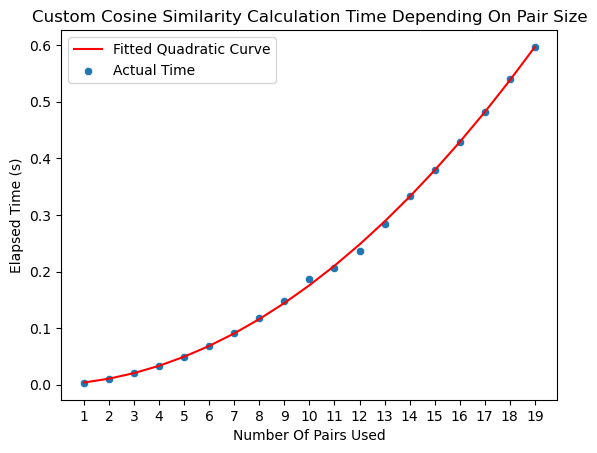

Steepness: 0.0015381630641796258
Slope: 0.0021540943798716537
Intercept: 0.00031001824241174596
Total Elapsed Time: 4.214431047439575 seconds


In [183]:
# Calculating and plotting elapsed time for custom cosine similarity for all pairs
elapsedTimeListAllPairsCustomCosine = allPairsCustomCosineElapsedTime(dfAllPairs)
plotPairSizeElapsedTime(elapsedTimeListAllPairsCustomCosine, "Custom Cosine Similarity")
totalElapsedTimeAllPairsCustomCosine = sum(elapsedTimeListAllPairsCustomCosine)
print("Total Elapsed Time: " + str(totalElapsedTimeAllPairsCustomCosine) + " seconds")

In [184]:
# Function to measure the time taken for Jaccard similarity calculations for all pairs
def allPairsJaccardElapsedTime(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        for j in i: jaccard(dict(j.iloc[:, 0]), dict(j.iloc[:, 1]))
        endTime = time.time()
        elapsedTime = endTime - startTime
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

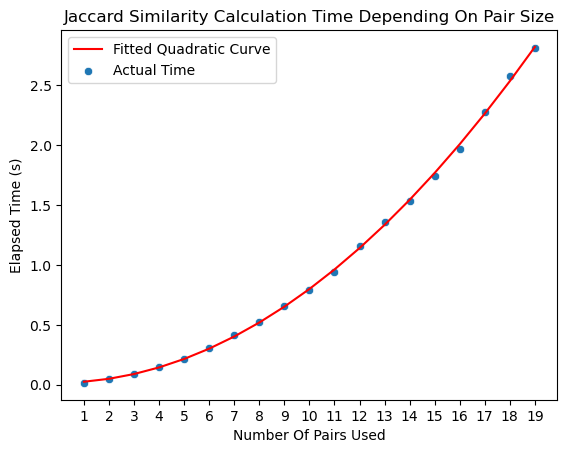

Steepness: 0.007693516771840048
Slope: 0.0013296937737866665
Intercept: 0.016010101363494456
Total Elapsed Time: 19.5598201751709 seconds


In [185]:
# Calculating and plotting elapsed time for Jaccard similarity for all pairs
elapsedTimeListAllPairsJaccard = allPairsJaccardElapsedTime(dfAllPairs)
plotPairSizeElapsedTime(elapsedTimeListAllPairsJaccard, "Jaccard Similarity")
totalElapsedTimeAllPairsJaccard = sum(elapsedTimeListAllPairsJaccard)
print("Total Elapsed Time: " + str(totalElapsedTimeAllPairsJaccard) + " seconds")

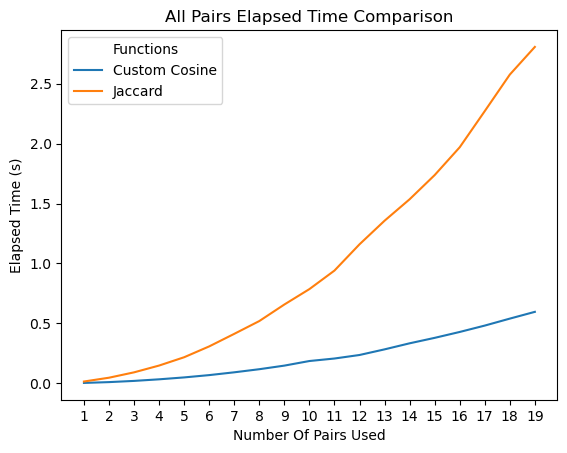

Custom Cosine Total Elapsed Time: 4.214431047439575 seconds
Jaccard Total Elapsed Time: 19.5598201751709 seconds


In [186]:
# Comparing the elapsed times of custom cosine and Jaccard similarities for all pairs
compareElapsedTime("All Pairs",
                   elapsedTimeListAllPairsCustomCosine,
                   elapsedTimeListAllPairsJaccard,
                   numOfTotalPairsList,
                   "Custom Cosine",
                   "Jaccard",
                   "Number Of Pairs Used")

Our investigation into the computational efficiency of cosine and Jaccard similarity calculations yielded interesting results. We found that both algorithms display a quadratic time complexity (O(n^2)) as the number of vector pairs grows. Notably, the custom cosine similarity function consistently outperformed the Jaccard similarity function in various iterations. This discovery holds significant implications for large-scale data science applications, underscoring the importance of choosing efficient computational methods when confronted with a rapidly increasing number of comparisons.

# QUESTİON4

This section will center on enhancing the computation of cosine similarity, a critical metric in vector analysis within the realm of data analytics. The main challenge involves efficiently handling the growing computational demands as datasets expand. To tackle this issue, we will explore two distinct computational methods: a traditional single-threaded approach and an innovative multi-threaded approach. Our goal is to assess the performance and efficiency enhancements that parallel processing can bring, particularly when dealing with extensive sets of vector pairs.

In [187]:

def customCosineMultiprocess(df):
    startTime = time.time()
    for i in df: customCosine(i.iloc[:, 0].values, i.iloc[:, 1].values)
    endTime = time.time()
    elapsedTime = endTime - startTime
    return elapsedTime

In [188]:
# Function to measure the time taken for custom cosine similarity calculations using multiprocessing
def allPairsCustomCosineMultiprocessElapsedTime(df):
    elapsedTimeList = joblib.Parallel(n_jobs = len(df))(joblib.delayed(customCosineMultiprocess)(dfSub) for dfSub in df)
    return elapsedTimeList

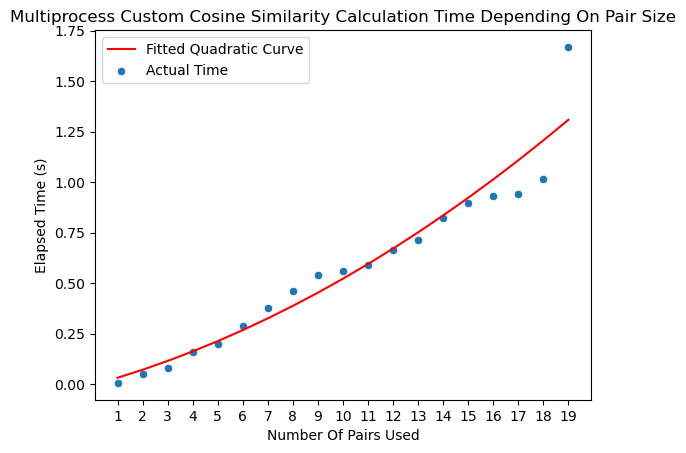

Steepness: 0.0018273859636375178
Slope: 0.03443688683887336
Intercept: -0.004744467230614058
Total Elapsed Time: 3.7193830013275146 seconds


In [189]:
# Measuring and plotting the total elapsed time for multiprocessing-based custom cosine similarity calculation
startTime = time.time()
elapsedTimeListAllPairsMultiprocessCustomCosine = allPairsCustomCosineMultiprocessElapsedTime(dfAllPairs)
endTime = time.time()
totalElapsedTimeAllPairsMultiprocessCustomCosine = endTime - startTime
plotPairSizeElapsedTime(elapsedTimeListAllPairsMultiprocessCustomCosine, "Multiprocess Custom Cosine Similarity")
print("Total Elapsed Time: " + str(totalElapsedTimeAllPairsMultiprocessCustomCosine) + " seconds")

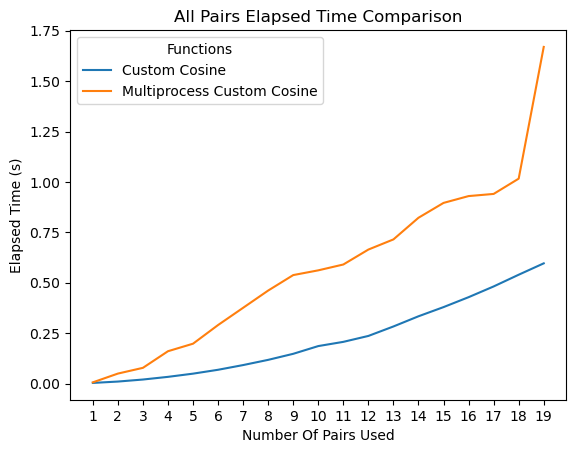

Custom Cosine Total Elapsed Time: 4.214431047439575 seconds
Multiprocess Custom Cosine Total Elapsed Time: 3.7193830013275146 seconds


In [190]:
# Comparing the elapsed times of single-process and multi-process custom cosine similarities for all pairs
compareElapsedTime("All Pairs",
                   elapsedTimeListAllPairsCustomCosine,
                   [elapsedTimeListAllPairsMultiprocessCustomCosine, totalElapsedTimeAllPairsMultiprocessCustomCosine],
                   numOfTotalPairsList,
                   "Custom Cosine",
                   "Multiprocess Custom Cosine",
                   "Number Of Pairs Used")

After implementing and assessing both the single-threaded and multi-threaded approaches for cosine similarity calculation, we noticed a marked difference in their performance. The multi-threaded method, harnessing the power of parallel processing, exhibited a significant reduction in computation time when compared to the single-threaded approach. This contrast became especially pronounced as the dataset size and the number of vector pairs grew exponentially. These results underscore the effectiveness of parallel processing in handling computations involving large-scale data, delivering a substantial boost in both speed and efficiency.








# 5

In the final section, our objective is to examine the efficiency of computing cosine similarity between vectors using two distinct methods: a custom cosine function and Strassen's matrix multiplication algorithm. Our emphasis will be on evaluating the performance of these methods as the number of vector pairs increases in accordance with a triangular series. This approach simulates the escalating computational requirements commonly encountered in data analysis and machine learning, offering valuable insights into the effectiveness of traditional versus matrix-based computational strategies in real-world scenarios.

In [191]:
dfStrassenCut = df[:5]
dfAllPairsStrassenCut = []

# Generating all possible pairs of columns from the DataFrame
for i in range(2, numOfTotalPairs + 1):
    temp = []
    for j in range(i - 1):
        for k in range(j + 1, i):
            df1 = dfStrassenCut.iloc[:, j]
            df2 = dfStrassenCut.iloc[:, k]
            newDf = pd.concat([df1, df2], axis = 1, join = 'inner')
            temp.append(newDf)
    dfAllPairsStrassenCut.append(temp)

In [192]:
# Function to split a matrix into four equal parts
def splitMatrix(A):
    rows, cols = A.shape
    rowSplit, colSplit = rows // 2, cols // 2
    return A[:rowSplit, :colSplit], A[:rowSplit, colSplit:], A[rowSplit:, :colSplit], A[rowSplit:, colSplit:]

# Function for Strassen's matrix multiplication algorithm
def strassenMatrixMultiplication(A, B):
    if len(A) == 1: return A * B
    A11, A12, A21, A22 = splitMatrix(A)
    B11, B12, B21, B22 = splitMatrix(B)
    M1 = strassenMatrixMultiplication(A11 + A22, B11 + B22)
    M2 = strassenMatrixMultiplication(A21 + A22, B11)
    M3 = strassenMatrixMultiplication(A11, B12 - B22)
    M4 = strassenMatrixMultiplication(A22, B21 - B11)
    M5 = strassenMatrixMultiplication(A11 + A12, B22)
    M6 = strassenMatrixMultiplication(A21 - A11, B11 + B12)
    M7 = strassenMatrixMultiplication(A12 - A22, B21 + B22)
    C11 = M1 + M4 - M5 + M7
    C12 = M3 + M5
    C21 = M2 + M4
    C22 = M1 - M2 + M3 + M6
    C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))
    return C

# Function to round up a matrix size to the next power of 2
def nextPowerOf2(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

# Function to pad a matrix to the next power of 2 size
def padMatrixToPowerOf2(A):
    size = nextPowerOf2(max(A.shape))
    paddedMatrix = np.zeros((size, size))
    paddedMatrix[:A.shape[0], :A.shape[1]] = A
    return paddedMatrix

In [193]:
# Function to calculate cosine similarity using Strassen's matrix multiplication
def strassenCustomCosine(v1, v2):
    v1, v2 = np.array(v1), np.array(v2)
    A = np.diag(v1)
    B = np.diag(v2)
    paddedA = padMatrixToPowerOf2(A)
    paddedB = padMatrixToPowerOf2(B)
    dotProduct = np.trace(strassenMatrixMultiplication(paddedA, paddedB))
    normV1 = math.sqrt(np.trace(strassenMatrixMultiplication(paddedA, paddedA)))
    normV2 = math.sqrt(np.trace(strassenMatrixMultiplication(paddedB, paddedB)))
    if normV1 == 0 or normV2 == 0: return 0
    return dotProduct / (normV1 * normV2)

In [194]:
# Function to measure the time taken for Strassen's custom cosine similarity calculations for all pairs
def allPairsStrassenCustomCosineElapsedTime(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        for j in i: strassenCustomCosine(j.iloc[:, 0].values, j.iloc[:, 1].values)
        endTime = time.time()
        elapsedTime = endTime - startTime
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

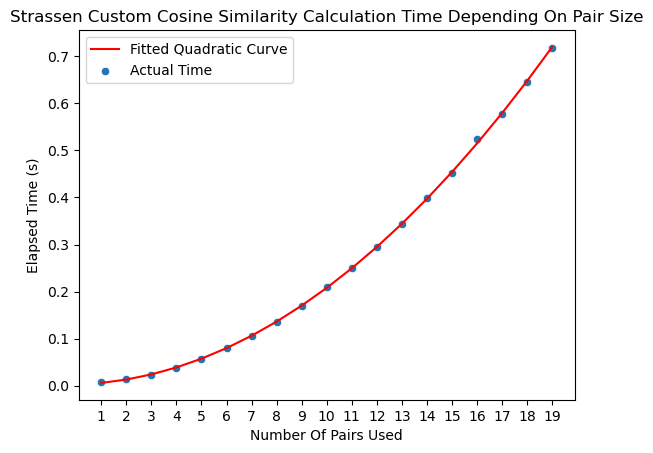

Steepness: 0.0019128629785560847
Slope: 0.001408327289728395
Intercept: 0.0025528193236480368
Total Elapsed Time: 5.040857315063477 seconds


In [195]:
# Calculating and plotting elapsed time for Strassen's custom cosine similarity
elapsedTimeListAllPairsStrassenCustomCosine = allPairsStrassenCustomCosineElapsedTime(dfAllPairsStrassenCut)
plotPairSizeElapsedTime(elapsedTimeListAllPairsStrassenCustomCosine, "Strassen Custom Cosine Similarity")
totalElapsedTimeAllPairsStrassenCustomCosine = sum(elapsedTimeListAllPairsStrassenCustomCosine)
print("Total Elapsed Time: " + str(totalElapsedTimeAllPairsStrassenCustomCosine) + " seconds")

In [196]:
# Function to measure the time taken for custom cosine similarity calculations for all pairs with additional iterations for accuracy
def allPairsCustomCosineElapsedTimeV2(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        for k in range(20):
            for j in i: customCosine(j.iloc[:, 0].values, j.iloc[:, 1].values)
        endTime = time.time()
        elapsedTime = (endTime - startTime) / 20
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

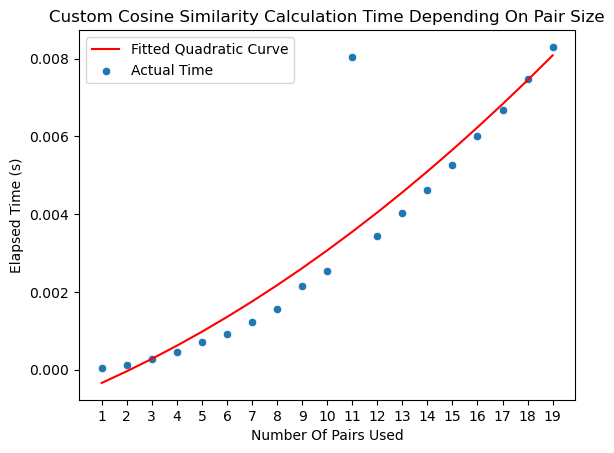

Steepness: 9.923174817692216e-06
Slope: 0.00026970929825623777
Intercept: -0.000621626685421718
Total Elapsed Time: 0.06394410133361816 seconds


In [197]:
# Calculating and plotting elapsed time for custom cosine similarity
elapsedTimeListAllPairsCustomCosineV2 = allPairsCustomCosineElapsedTimeV2(dfAllPairsStrassenCut)
plotPairSizeElapsedTime(elapsedTimeListAllPairsCustomCosineV2, "Custom Cosine Similarity")
totalElapsedTimeAllPairsCustomCosineV2 = sum(elapsedTimeListAllPairsCustomCosineV2)
print("Total Elapsed Time: " + str(totalElapsedTimeAllPairsCustomCosineV2) + " seconds")

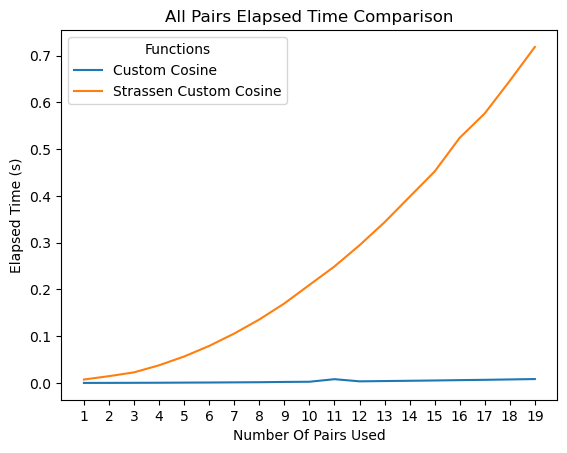

Custom Cosine Total Elapsed Time: 0.06394410133361816 seconds
Strassen Custom Cosine Total Elapsed Time: 5.040857315063477 seconds


In [198]:
# Comparing the elapsed times of Strassen's and custom cosine similarities for all pairs
compareElapsedTime("All Pairs",
                   elapsedTimeListAllPairsCustomCosineV2,
                   elapsedTimeListAllPairsStrassenCustomCosine,
                   numOfTotalPairsList,
                   "Custom Cosine",
                   "Strassen Custom Cosine",
                   "Number Of Pairs Used")

Our examination, comparing the custom cosine method with Strassen's matrix multiplication, yielded an unexpected outcome: the conventional cosine method outperformed Strassen's algorithm. This discovery underscores a fundamental computational principle: advanced algorithms, while theoretically efficient, may not always provide practical speed advantages in particular applications. The exponential rise in computation time as the number of vector pairs increased highlights the difficulties associated with processing large datasets and underscores the importance of judiciously selecting the most appropriate algorithm based on the specific data structure and application context.

# # Conclusion


This study delves into document similarity measures within the context of Leo Tolstoy's "War and Peace," framed around five key inquiries aimed at evaluating the efficiency and effectiveness of algorithms. It underscores the pivotal role of algorithm implementation, as demonstrated by performance disparities between NumPy's dot product and custom implementations when computing cosine similarities. Jaccard's similarity measure offers a distinct computational profile, shedding light on algorithmic efficiency in text analysis from different angles.

The research further explores scalability, especially in the computation of all-pairs similarities, revealing how various similarity measures perform in terms of efficiency across diverse data scenarios. The adoption of parallel computing techniques for these measures shows promise in significantly bolstering computational speed.

Furthermore, the application of Strassen's matrix multiplication in cosine similarity calculations puts theoretical computer science concepts into practical use, providing insights into algorithm scalability and optimization.

In summary, this report underscores the intricate interplay of theoretical and empirical factors in algorithm development for document similarity analysis. These findings hold significance for future research and the development of more efficient data analysis tools across various domains, emphasizing a balanced approach to assessing and implementing algorithms for large-scale text analysis.








Submission length is 1157
